In [9]:
from main import main
import matplotlib.pyplot as plt
import numpy as np

In [6]:
precisions, recalls, f1_scores, timings = main()

Chosen fraction = 10.0 %
Run 0
Running PARIS...
PARIS output:
 Starting PARIS... 
  Settings specified on command line
done
PARIS is now running!
For information about the current state of affairs, look into
    ./run__20200616152200.txt
PARIS terminated after 20476 milliseconds

Computed precision per iteration:
    Run 0: 1.0
    Run 1: 0.7753120665742025
    Run 2: 0.9881856540084388
    Run 3: 0.8276036400404448
    Run 4: 0.83570581257414
    Run 5: 0.8436297804933243
    Run 6: 0.8872843210802701
    Run 7: 0.9065656565656566
    Run 8: 0.9194133417442044
    Run 9: 0.9214787656584174
Computed recall per iteration:
    Run 0: 0.08804297057449789
    Run 1: 0.08703098240697493
    Run 2: 0.0911567803207224
    Run 3: 0.1274326638642379
    Run 4: 0.21936789662151643
    Run 5: 0.29020706834812393
    Run 6: 0.3682858477347034
    Run 7: 0.41919663708547406
    Run 8: 0.4538377705122217
    Run 9: 0.46956250973065544
Computed F1 score per iteration:
    Run 0: 0.16183730414251984
 

In [7]:
precisions

[{0: 1.0,
  1: 0.7753120665742025,
  2: 0.9881856540084388,
  3: 0.8276036400404448,
  4: 0.83570581257414,
  5: 0.8436297804933243,
  6: 0.8872843210802701,
  7: 0.9065656565656566,
  8: 0.9194133417442044,
  9: 0.9214787656584174},
 {0: 1.0,
  1: 0.7649930264993027,
  2: 0.9930915371329879,
  3: 0.8674121405750799,
  4: 0.8187016481668349,
  5: 0.8233379823337982,
  6: 0.8797065070476926,
  7: 0.9020896528479946,
  8: 0.9176341386884217,
  9: 0.9167294082216534},
 {0: 1.0,
  1: 0.7755376344086021,
  2: 0.9898132427843803,
  3: 0.8525703200775946,
  4: 0.8059701492537313,
  5: 0.8557904007045355,
  6: 0.8895137880986937,
  7: 0.9149777558082056,
  8: 0.9233542319749216,
  9: 0.9248246416590424}]

In [15]:
precision_means = []
precision_stds = []
last_iter = max(precisions[0].keys())
for i in range(last_iter+1):
    iter_values = [val[i] for val in precisions]
    precision_means.append(np.mean(iter_values))
    precision_stds.append(np.std(iter_values))

<ErrorbarContainer object of 3 artists>

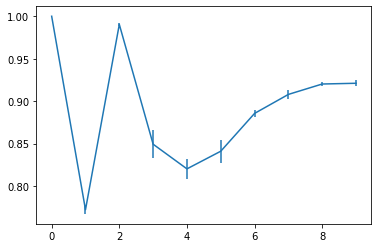

In [18]:
plt.errorbar(range(last_iter+1), precision_means, yerr=precision_stds)

In [19]:
recall_means = []
recall_stds = []
last_iter = max(recalls[0].keys())
for i in range(last_iter+1):
    iter_values = [val[i] for val in recalls]
    recall_means.append(np.mean(iter_values))
    recall_stds.append(np.std(iter_values))

<ErrorbarContainer object of 3 artists>

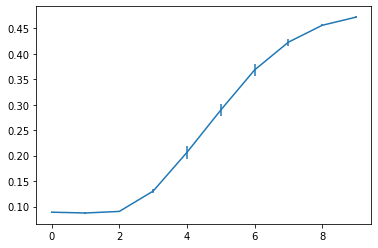

In [20]:
plt.errorbar(range(last_iter+1), recall_means, yerr=recall_stds)

In [21]:
f1_score_means = []
f1_score_stds = []
last_iter = max(f1_scores[0].keys())
for i in range(last_iter+1):
    iter_values = [val[i] for val in f1_scores]
    f1_score_means.append(np.mean(iter_values))
    f1_score_stds.append(np.std(iter_values))

<ErrorbarContainer object of 3 artists>

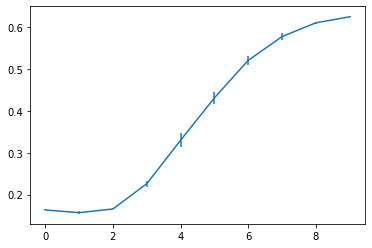

In [22]:
plt.errorbar(range(last_iter+1), f1_score_means, yerr=f1_score_stds)

In [31]:
def bootstrap_metric(metric_list, n_iter):
    """Compute bootstrap means list to be used for computing confidence intervals
        using bootstrap resample"""
    means = []
    last_iter = max(metric_list[0].keys())
    metric_last = [val[last_iter] for val in metric_list]
    for i in range(n_iter):
        # Bootstrap
        metric_sample = np.random.choice(metric_last, size=len(metric_last), replace=True)
        means.append(np.mean(metric_sample))

    return means

In [23]:
def confidence_interval(means, conf_percent):
    # Computing low quantile (2.5 in our case)
    low_p = ((1.0 - conf_percent) / 2.0) * 100
    lower = np.percentile(means, low_p)

    # Computing high quantile
    high_p = (conf_percent + ((1.0 - conf_percent) / 2.0)) * 100
    upper = np.percentile(means, high_p)

    return [lower, upper]

In [32]:
means_precision = bootstrap_metric(precisions, 1000)

In [35]:
interval = confidence_interval(means_precision, 0.95)
print(interval)

[0.9167294082216534, 0.9248246416590424]


In [57]:
def plot_confidence(means_metric, interval):
    # Computing the mean error
    mean = np.mean(means_metric)

    # Plot scores
    plt.hist(means_metric, bins=5)

    # Plot of two interval lines
    plt.axvline(interval[0], color='k', linestyle='dashed', linewidth=1)
    plt.axvline(interval[1], color='k', linestyle='dashed', linewidth=1)
    plt.axvline(mean, color='r', linestyle='dashed', linewidth=1)

    plt.title("95.0 % confidence interval")
    plt.xlabel("A certain metric mean")
    plt.ylabel("Count")

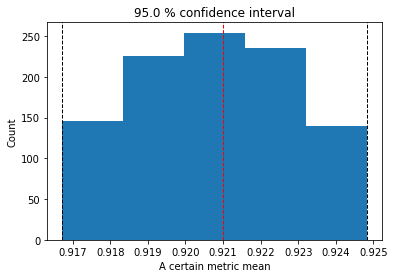

In [58]:
plot_confidence(means_precision, interval)

In [68]:
def plot_error(means_metric, interval):
    #computing the error bar for confidence interval
    error = interval[1] - interval[0]
    mean = np.mean(means_metric)
    
    # Plotting on bar plot
    plt.barh(["Precision"], mean,
             xerr=error,
             height=0.1,
             color=["dodgerblue"])
    plt.title("Mean error bar plot with confidence interval")
    plt.xlabel("Mean error")
    plt.ylabel("Models")

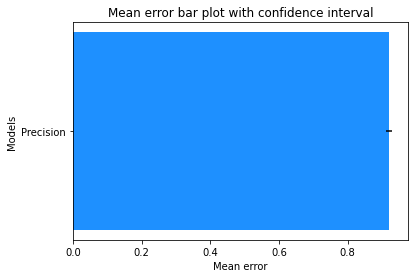

In [69]:
plot_error(means_precision, interval)